# Trabalho Final Instalações Industriais

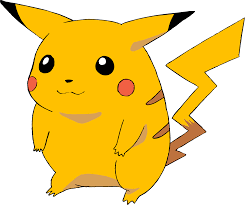

O primeiro passo é selecionar os motores, o primeiro motor selecionado foi o da seguinte ficha tecnica:

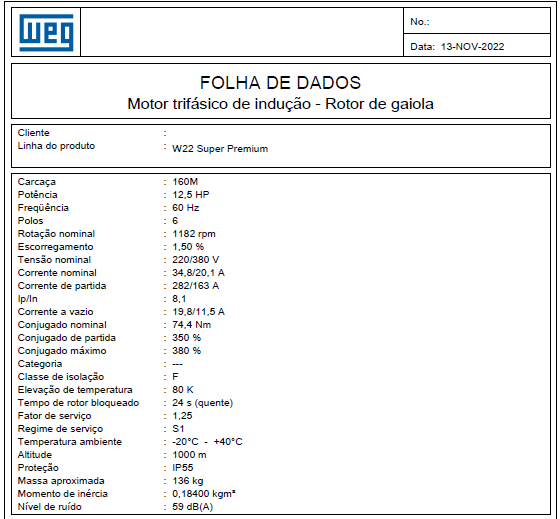

Com isso temos os seguintes valores:

In [1]:
Mst_r = 3.5; %relação conjugado de partida/nominal
Mk_r = 3.8; %relação conjugado máx/nominal
Ist_r = 8.1; %relação corrente de partida/nominal
ns = 1200; %velocidade sincrona
nr = 1182; %velocidade nominal
FP = 0.75; %Fator de potência plena carga
Pn = 9321.248;
In = 20.1; Vl = 380; %corrente e tensão nominal de linha (380 V)
tn = 74.4; %torque nominal [Nm]



The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are unlikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update its internal list of open figure windows.
The qt toolkit is recommended instead.



## Curvas de Desempenho Motor 1
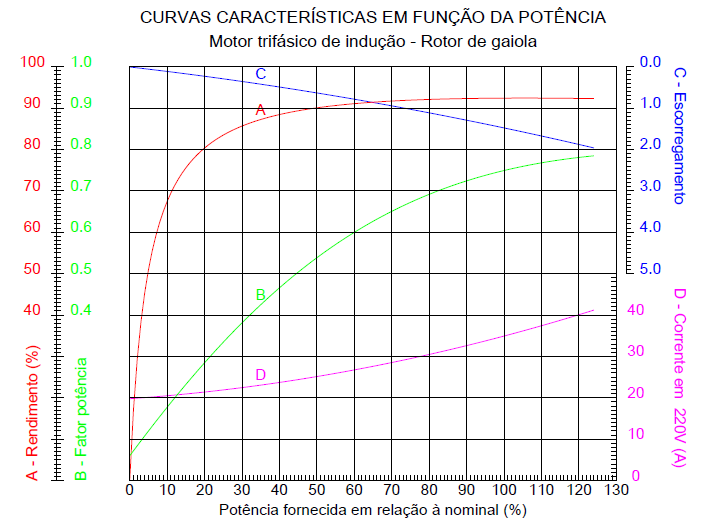

Então aproximamos 10 pontos em cada uma dessas curvas, assim temos os seguintes dados:

Eff =

 Columns 1 through 8:

   74.759   81.242   85.154   88.628   89.911   91.086   91.883   92.509

 Columns 9 and 10:

   92.770   92.509



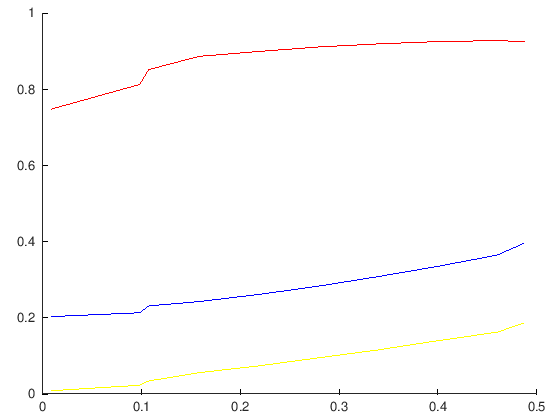

In [3]:
% curvas
P2 = 3700*[0.02057, 0.246667, 0.26994, 0.39858, 0.55026, 0.70160, 0.85294, 1.00463, 1.15907, 1.22786]; %Potência
Eff = [74.759, 81.242, 85.154, 88.628, 89.911, 91.086, 91.883, 92.509, 92.770, 92.509] %Eficiência
s = [0.085, 0.230, 0.342, 0.560, 0.738, 0.947, 1.154, 1.394, 1.624, 1.863]; %Escorregamento
I1 =[  20.319 21.325 23.120 24.261 26.135 28.291 30.775 33.461 36.462 39.567 ]; %Corrente
hold on
plot(P2/9321.248,Eff/100,'r') % 100 é o máximo mostrado no gráfico do fabricante
plot(P2/9321.248,s/10,'y') % 10 é o máximo mostrado no gráfico do fabricante
plot(P2/9321.248,I1/100,'b') % 20 é o máximo mostrado no gráfico do fabricante
% Compare com os dados do fabricante se os gráficos ficaram parecidos

## Aplicando o algoritimo

In [4]:
%Resistências
yr1 = P2*100./Eff - P2*100./(100-s); %Estimação da inclinação (R1)
xr1 = 3*I1.^2;

%minimização do erro quadrático (pseudo-inversão)

A = [xr1'  ones(length(xr1),1)];
C = pinv(A)*yr1'; YR1=C(1)*xr1+C(2);
r1 = C(1); Prot = C(2);

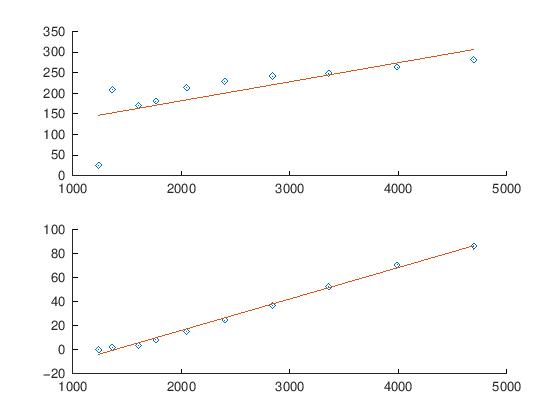

In [5]:
%Estimação da inclinação (R2)
yr2_= P2.*(s./(100-s));xr2_=xr1;
%minimização do erro quadrático (pseudo-inversão)
A = [xr2_'  ones(length(xr2_),1)];
C2 = pinv(A)*yr2_'; YR2 = C2(1)*xr2_+C2(2);
r2 = C2(1);

%Plot
figure(2)
subplot(2,1,1) % Em vermelho a reta que estima R1
hold on
plot(xr1,yr1,'d')
plot(xr1,YR1)

subplot(2,1,2)
hold on

plot(xr2_,yr2_,'d') % Em vermelho a reta que estima R2'
plot(xr2_,YR2)

In [11]:
sr = (ns-nr)/ns;                                   % escorregamento nominal
sk = sr*(Mst_r + sqrt(Mst_r^2-1));                 % escorregamento durante o conjugado máximo
I2 = I1*FP*sqrt(1+(sr/sk)^2);                      % Cálculo da corrente do rotor baseada no fator de potência
r_20 = (1/3)*(ns/nr)*(Mst_r*P2/(Ist_r*I2).^2);     % resistência do rotor durante a partida
gr = log(r_20/r2)/(sqrt(1-sr));                    % Fator de variação da resistência do rotor 
r_2k = r_20*exp(gr*sqrt(1-sk));                    % resistência do rotor durante o conjugado máximo
xs = sqrt((Vl/(Ist_r*In))^2 - (r1+r_20)^2);        % reatância de curto circuito
x1 = (0.6 - 0.3*Mst_r/Mk_r)*xs;                    % reatância de dispersão do estator
x_20 = xs - x1;                                    % reatância do rotor na partida
x_2k = r_2k/sk;                                    % reatância do rotor no conjugado máximo
gx = log(x_20/x_2k)/sqrt(1-sk);                    % fator de variação da reatância
x2= x_20*exp(gx*sqrt(1-sr));                       % reatância de dispersão do rotor referenciada do estator

In [12]:
%parâmetros de magnetização

E = Vl - In*(r1^2 + x1^2)^0.5;                     % Tensão sobre o ramo de magnetização
rm = (E^2)/Prot;                                   % Resistência de magnetização 
In2 = In*FP*sqrt(1+(sr/sk)^2);                     % Corrente do rotor em plena carga
xm = E/sqrt(In^2-In2^2-(E/rm)^2);                  % Reatância de magnetização

% Display
sprintf('Resistência Estator (r1): %.4f ; Reatância Estator (x1): %.4f;', r1, x1) 
sprintf('Resistência Rotor (r2"): %.4f ; Reatância do Rotor (x2"): %.4f;', r2,x2)
sprintf('Resistência Magnetização (rm): %.4f ; Reatância de Magnetização: %.4f;', rm, xm)

ans = Resistência Estator (r1): 0.0462 ; Reatância Estator (x1): 0.7541;
ans = Resistência Rotor (r2"): 0.0262 ; Reatância do Rotor (x2"): 0.7821;
ans = Resistência Magnetização (rm): 1487.4094 ; Reatância de Magnetização: 27.8284;


## Torque-Velocidade

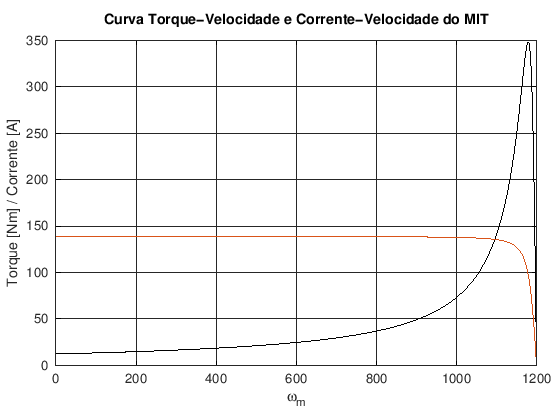

In [13]:
ws = ns*2*pi/60; % velocidade síncrona angular (rad/s)
% Calculando a tensão e impedância de Thevenin
% Desconsiderando rm, verifique que a diferença é pequena
%v_th = Vl / sqrt(3) * ( xm / sqrt(r1^2 + (x1 + xm)^2) );
%z_th = j*xm * (r1 + j*x1) / (r1 + j*(x1 + xm));
% Considerando rm
v_th = Vl / sqrt(3) / ((1 + r1/rm + x1/xm) + j*(x1/rm-r1/xm));
z_th = (r1 + j*x1) / ((1 + r1/rm + x1/xm) + j*(x1/rm-r1/xm));
r_th = real(z_th);
x_th = imag(z_th);
s = (0:1:500) / 500; % escorregamento
s(1) = 0.001;
nm = (1 - s) * ns; % velocidade angular
% Calcular o torque
for ii = 1:501
t_m(ii) = (3 * v_th^2 * r2 / s(ii)) / ...
(ws * ((r_th + r2/s(ii))^2 + (x_th + x2)^2) );
end
Ir=v_th./(sqrt(((r2./s)+r1).^2+(x1+x2)^2));
% Plotar a curva torque-velocidade
plot(nm,t_m,'Color','k','LineWidth',2.0);
hold on;
grid on;
plot(nm,Ir);
ylabel('Torque [Nm] / Corrente [A]');
xlabel('\omega_m');
title('Curva Torque-Velocidade e Corrente-Velocidade do MIT');
hold off;

## Comparando com o catálogo

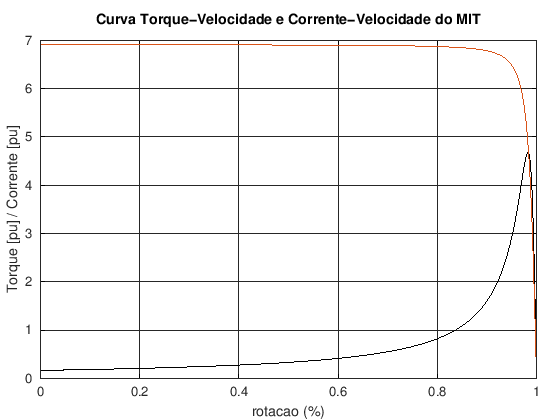

In [14]:
% Plotar a curva torque-velocidade
plot(1-s,t_m/tn,'Color','k','LineWidth',2.0);
hold on;
grid on;
plot(1-s,Ir/In);
ylabel('Torque [pu] / Corrente [pu]');
xlabel('rotacao (%)');
title('Curva Torque-Velocidade e Corrente-Velocidade do MIT');
hold off;

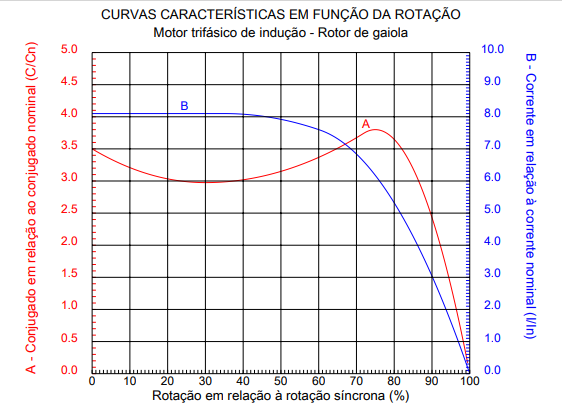

## Curva Velocidade Eficiência

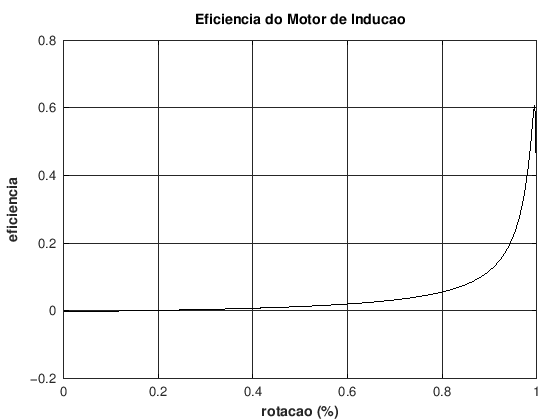

In [15]:
vf = Vl / sqrt(3); % tensão de fase
nm = (1 - s) * ns; % velocidade angular do motor
for ii = 1:501
z_s(ii) = r1+(x1); %impedância do estator
z_r(ii) = (r2/s(ii))+(x2); %impedância do rotor
z_m(ii) = xm ; %impedância de magnetização
z_eq(ii) = z_s(ii)+((z_m(ii)*z_r(ii))/(z_m(ii)+z_r(ii))); %impedância equivalente
i_s(ii) = vf/z_eq(ii) ; %corrente no estator
p_in(ii) = 3*vf*(real(i_s(ii))); %potência de entrada
e_s(ii) = vf-(i_s(ii)*z_s(ii));
i_r(ii) = e_s(ii)/z_r(ii); %corrente no rotor
p_conv(ii) = 3*(((abs(i_r(ii)))^2)*((r2)*((1-s(ii))/(s(ii)))));
p_out(ii) = ((p_conv(ii)))-18-220; %potência de saída
eff(ii) = (p_out(ii))/(p_in(ii)); %eficiência
end
% Plotar a curva velocidade-eficiência
plot(1-s,eff,'Color','k','LineWidth',2.0);
hold on;
xlabel('rotacao (%)','Fontweight','Bold');
ylabel('eficiencia','Fontweight','Bold');
title ('Eficiencia do Motor de Inducao','Fontweight','Bold');
grid on;
hold off;